<a href="https://colab.research.google.com/github/Pranav-Kumar14/Handwriting-Image-Detection/blob/main/Handwriting_Image_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[MLP (Non-CNN)] Epoch 1/10, Loss: 1.7778
[MLP (Non-CNN)] Epoch 2/10, Loss: 1.1060
[MLP (Non-CNN)] Epoch 3/10, Loss: 0.9158
[MLP (Non-CNN)] Epoch 4/10, Loss: 0.8257
[MLP (Non-CNN)] Epoch 5/10, Loss: 0.7612
[MLP (Non-CNN)] Epoch 6/10, Loss: 0.6586
[MLP (Non-CNN)] Epoch 7/10, Loss: 0.6274
[MLP (Non-CNN)] Epoch 8/10, Loss: 0.6169
[MLP (Non-CNN)] Epoch 9/10, Loss: 0.5948
[MLP (Non-CNN)] Epoch 10/10, Loss: 0.5774

=== MLP (Non-CNN) Evaluation Results ===
Accuracy: 81.89%
              precision    recall  f1-score   support

           0      0.798     0.758     0.777       182
           1      0.799     0.790     0.794       176
           2      0.869     0.849     0.859       179
           3      0.831     0.815     0.823       157
           4      0.813     0.875     0.843       144
           5      0.783     0.892     0.834       186
           6      0.711     0.659     0.684       179
           7      0.794     0.799     0.797       179
           8      0.646     0.583     0.613

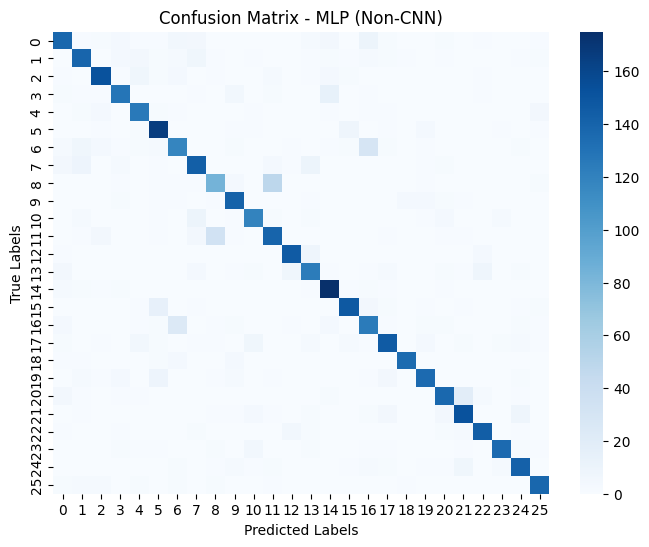

[EnhancedCNN (Your Model)] Epoch 1/10, Loss: 0.9617
[EnhancedCNN (Your Model)] Epoch 2/10, Loss: 0.5472
[EnhancedCNN (Your Model)] Epoch 3/10, Loss: 0.4655
[EnhancedCNN (Your Model)] Epoch 4/10, Loss: 0.4151
[EnhancedCNN (Your Model)] Epoch 5/10, Loss: 0.3826
[EnhancedCNN (Your Model)] Epoch 6/10, Loss: 0.3292
[EnhancedCNN (Your Model)] Epoch 7/10, Loss: 0.3130
[EnhancedCNN (Your Model)] Epoch 8/10, Loss: 0.3056
[EnhancedCNN (Your Model)] Epoch 9/10, Loss: 0.2959
[EnhancedCNN (Your Model)] Epoch 10/10, Loss: 0.2799

=== EnhancedCNN (Your Model) Evaluation Results ===
Accuracy: 91.28%
              precision    recall  f1-score   support

           0      0.866     0.890     0.878       182
           1      0.965     0.943     0.954       176
           2      0.965     0.922     0.943       179
           3      0.947     0.904     0.925       157
           4      0.902     0.958     0.929       144
           5      0.961     0.935     0.948       186
           6      0.821     0.

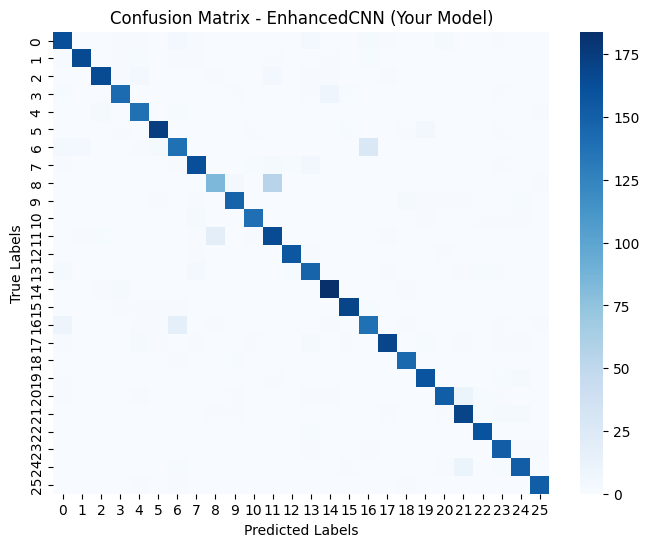

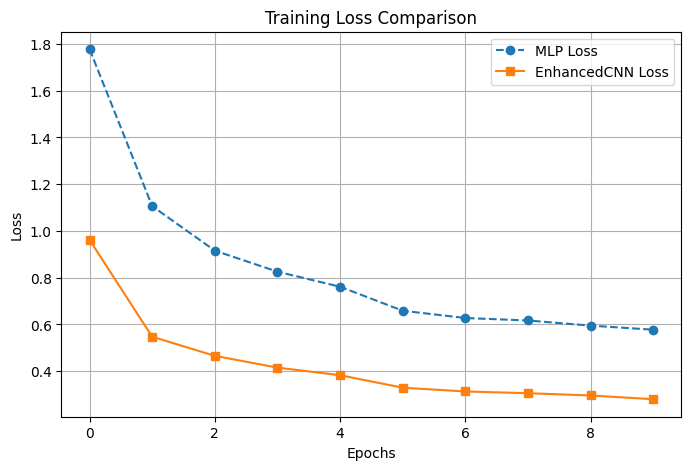

/tmp/ipython-input-2053459162.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Model', y='Accuracy (%)', palette=['gray', 'purple'])


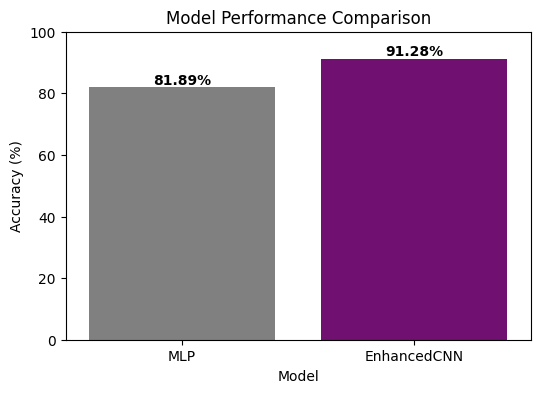


EnhancedCNN model saved to enhanced_emnist_cnn_best.pth


In [ ]:
import torch
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data_dir = "./data"
batch_size = 64
num_epochs = 10
learning_rate = 1e-3
random_seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform_train = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_test = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.EMNIST(root=data_dir, split='letters', train=True, download=True, transform=transform_train)
test_dataset = datasets.EMNIST(root=data_dir, split='letters', train=False, download=True, transform=transform_test)

full_dataset = ConcatDataset([train_dataset, test_dataset])
portion_size = int(0.3 * len(full_dataset))
unused_size = len(full_dataset) - portion_size
subset_30_percent, _ = random_split(full_dataset, [portion_size, unused_size], generator=torch.Generator().manual_seed(random_seed))

train_size = int(0.9 * len(subset_30_percent))
test_size = len(subset_30_percent) - train_size
new_train_subset, new_test_subset = random_split(subset_30_percent, [train_size, test_size], generator=torch.Generator().manual_seed(random_seed))

train_loader = DataLoader(new_train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(new_test_subset, batch_size=batch_size, shuffle=False)

class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(28*28, 512)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 27)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, 0.3)
    x = F.relu(self.fc2(x)) x = self.fc3(x)
    return x

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 27)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_and_evaluate(model, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), (labels - 1).to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"[{model_name}] Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), (labels - 1).to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"\n=== {model_name} Evaluation Results ===")
    print(f"Accuracy: {acc*100:.2f}%")
    print(classification_report(all_labels, all_preds, digits=3))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return acc, train_losses, cm, (all_labels, all_preds)

acc_mlp, loss_mlp, cm_mlp, pred_data_mlp = train_and_evaluate(MLP(), "MLP (Non-CNN)")
acc_cnn, loss_cnn, cm_cnn, pred_data_cnn = train_and_evaluate(EnhancedCNN(), "EnhancedCNN (Your Model)")

plt.figure(figsize=(8,5))
plt.plot(loss_mlp, label="MLP Loss", linestyle='--', marker='o')
plt.plot(loss_cnn, label="EnhancedCNN Loss", linestyle='-', marker='s')
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

data = {
    'Model': ['MLP', 'EnhancedCNN'],
    'Accuracy (%)': [acc_mlp*100, acc_cnn*100]
}
df = pd.DataFrame(data)

plt.figure(figsize=(6,4))
sns.barplot(data=df, x='Model', y='Accuracy (%)', palette=['gray', 'purple'])
plt.title("Model Performance Comparison")
plt.ylim(0, 100)
for i, v in enumerate(df['Accuracy (%)']):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')
plt.show()

torch.save(EnhancedCNN().state_dict(), "enhanced_emnist_cnn_best.pth")
print("\nEnhancedCNN model saved to enhanced_emnist_cnn_best.pth")



100%|██████████| 562M/562M [00:05<00:00, 98.1MB/s]



========== EMNIST Dataset Statistics ==========
Total images in full EMNIST dataset: 145600
30% subset size: 43680
  ↳ Train split (90%): 39312
  ↳ Test split (10%):  4368

Label Distribution (Train):
Letter A: 1492
Letter B: 1518
Letter C: 1558
Letter D: 1532
Letter E: 1491
Letter F: 1512
Letter G: 1538
Letter H: 1488
Letter I: 1500
Letter J: 1483
Letter K: 1513
Letter L: 1505
Letter M: 1488
Letter N: 1485
Letter O: 1550
Letter P: 1529
Letter Q: 1549
Letter R: 1545
Letter S: 1556
Letter T: 1488
Letter U: 1488
Letter V: 1453
Letter W: 1529
Letter X: 1514
Letter Y: 1523
Letter Z: 1485


/tmp/ipython-input-4162543046.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[chr(u + 64) for u in unique], y=counts, palette="viridis")


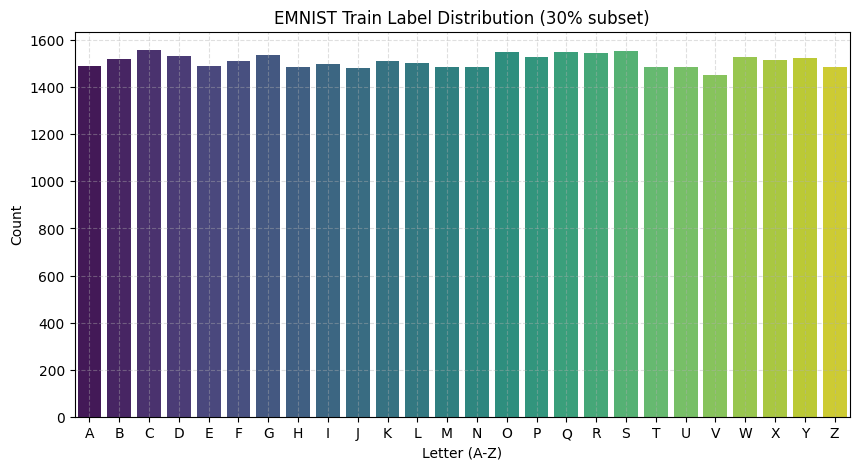

In [ ]:
import torch
from torch.utils.data import ConcatDataset, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = "./data"
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform_train = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.EMNIST(root=data_dir, split='letters', train=True, download=True, transform=transform_train)
test_dataset = datasets.EMNIST(root=data_dir, split='letters', train=False, download=True, transform=transform_test)

# Combine train and test
full_dataset = ConcatDataset([train_dataset, test_dataset])
full_len = len(full_dataset)

portion_size = int(0.3 * full_len)
unused_size = full_len - portion_size
subset_30_percent, _ = random_split(full_dataset, [portion_size, unused_size], generator=torch.Generator().manual_seed(random_seed))

train_size = int(0.9 * len(subset_30_percent))
test_size = len(subset_30_percent) - train_size
new_train_subset, new_test_subset = random_split(subset_30_percent, [train_size, test_size], generator=torch.Generator().manual_seed(random_seed))

print("\n========== EMNIST Dataset Statistics ==========")
print(f"Total images in full EMNIST dataset: {full_len}")
print(f"30% subset size: {len(subset_30_percent)}")
print(f"  ↳ Train split (90%): {train_size}")
print(f"  ↳ Test split (10%):  {test_size}")

def get_labels(dataset):
    labels = []
    for data, label in dataset:
        labels.append(int(label))
    return np.array(labels)

train_labels = get_labels(new_train_subset)
test_labels = get_labels(new_test_subset)

print("\nLabel Distribution (Train):")
unique, counts = np.unique(train_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Letter {chr(u + 64)}: {c}")

plt.figure(figsize=(10,5))
sns.barplot(x=[chr(u + 64) for u in unique], y=counts, palette="viridis")
plt.title("EMNIST Train Label Distribution (30% subset)")
plt.xlabel("Letter (A-Z)")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()
